In [1]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
from datetime import datetime

# Data extraction & Returns Overview

In [2]:
# Data Extraction
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol , start_date , end_date)
df = strat_mgr.df.copy()

df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2023-09-22,26564.056641,26726.078125,26495.533203,26579.568359,10578746709,0.000449,0.008701,3.038692
2023-09-23,26578.556641,26634.185547,26520.519531,26579.390625,7404700301,-0.000007,0.004286,3.038662
2023-09-24,26579.373047,26716.058594,26221.050781,26256.826172,8192867686,-0.012136,0.018878,2.989186
2023-09-25,26253.775391,26421.507812,26011.468750,26298.480469,11997833257,0.001586,0.015764,2.994949
2023-09-26,26294.757812,26389.884766,26090.712891,26217.250000,9985498161,-0.003089,0.011467,2.981431


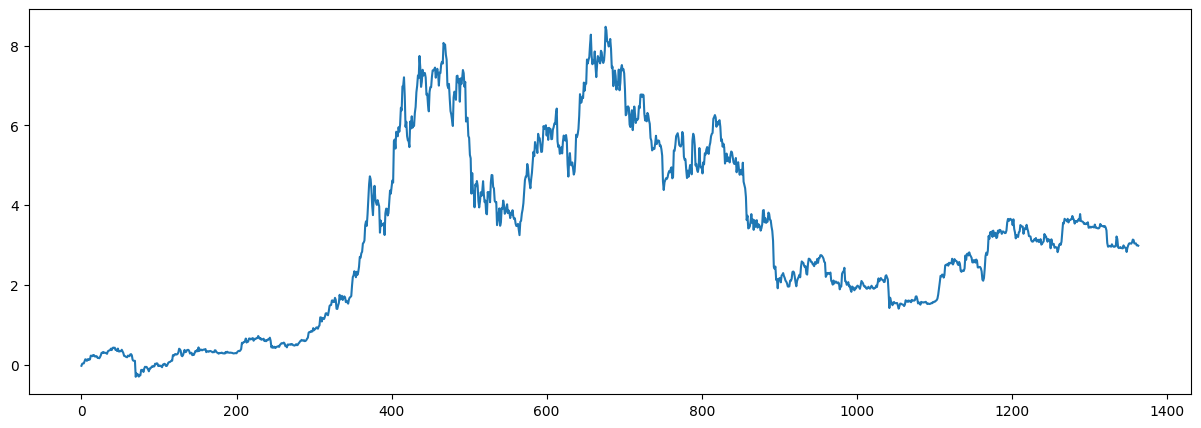

In [3]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

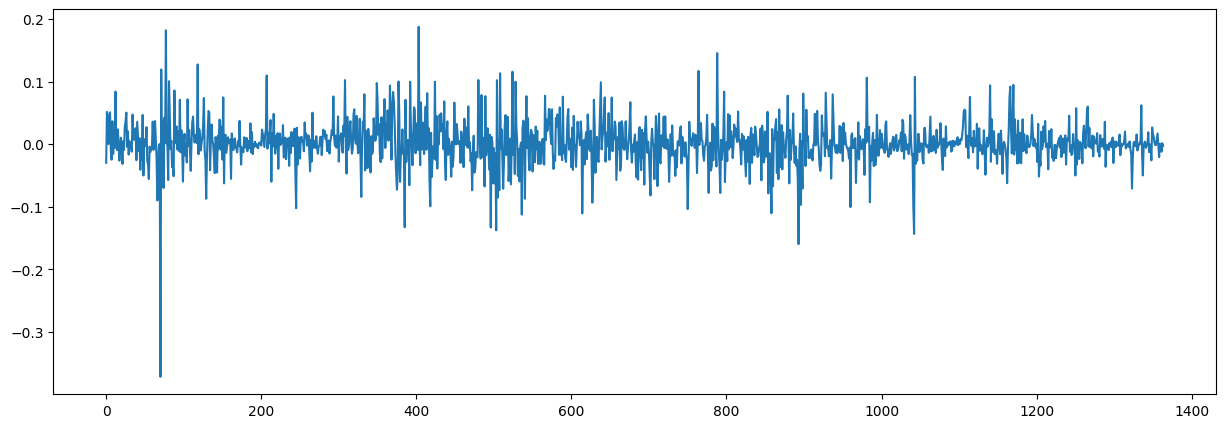

In [4]:
# Benchmark Returns Profile
fig = plt.figure(figsize=(15,5))
plt.plot(df["Returns"].values)
plt.show()

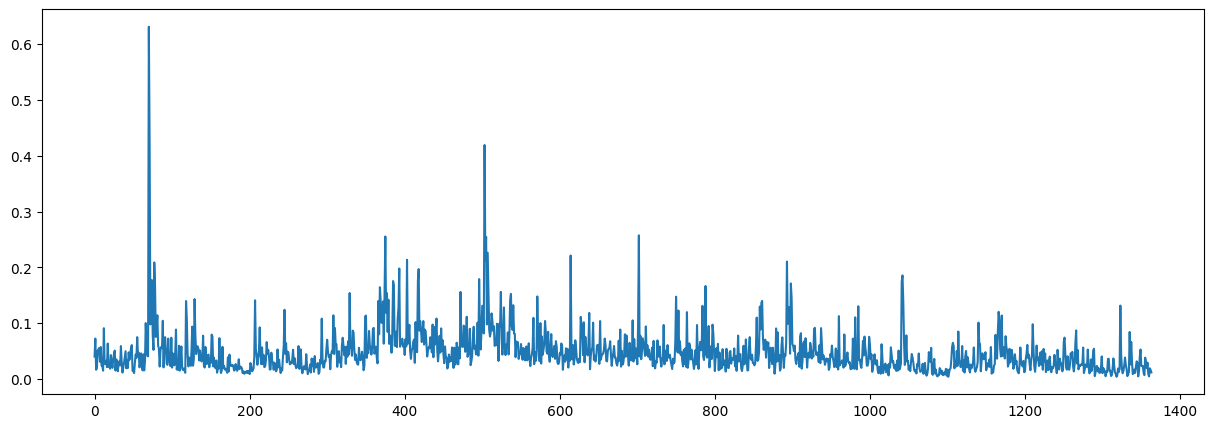

In [5]:
fig = plt.figure(figsize=(15,5))
plt.plot(df["Range"].values)
plt.show()

# Feature Engineering - Feature Expantion

In [6]:
df_fe = df.copy()

# Indicators

In [7]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi

df_fe["RSI_Return"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [8]:
# Add moving averages
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [9]:
# Day of the week
df_fe["DOW"] = df_fe.index.dayofweek

In [10]:
# Rolling Cumalitive returns
df_fe["Rolling_rets"] = df_fe["Returns"].rolling(window=30).sum()

In [11]:
# Rolling Cumalitive Range
df_fe["AVG_Range"] = df_fe["Range"].rolling(window=30).mean()

## Time Intervals

In [12]:
# Add Time Intervals
time_steps = [1,2]
time_features = ["Returns", "Range", "Rolling_rets"]
for ts in time_steps:
    for tf in time_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

### Feature Engineering

In [13]:
# Correct for stationarity
df_stationary = df_fe.copy()

df_stationary[["Open","High","Low","Volume"]] = df_stationary[["Open","High","Low","Volume"]].pct_change()

# ASSES DATA FOR ML READINESS

In [14]:
# Check for NaN
df_stationary = df_stationary.dropna()

In [15]:
# Check for inf values
dfobj = df_stationary.isin([np.inf,-np.inf])
count = np.isinf(dfobj).values.sum()

In [16]:
# Check for non numerical objects
df_stationary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1333 entries, 2020-02-02 to 2023-09-26
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1333 non-null   float64
 1   High             1333 non-null   float64
 2   Low              1333 non-null   float64
 3   Close            1333 non-null   float64
 4   Volume           1333 non-null   float64
 5   Returns          1333 non-null   float64
 6   Range            1333 non-null   float64
 7   Bench_C_Rets     1333 non-null   float64
 8   RSI              1333 non-null   float64
 9   RSI_Return       1333 non-null   float64
 10  MA_12            1333 non-null   float64
 11  MA_21            1333 non-null   float64
 12  DOW              1333 non-null   int64  
 13  Rolling_rets     1333 non-null   float64
 14  AVG_Range        1333 non-null   float64
 15  Returns_T1       1333 non-null   float64
 16  Range_T1         1333 non-null   float64
 

In [17]:
# describe dataframe
df_stationary.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,MA_21,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2
count,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,...,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000,1333.000000
mean,0.001428,0.001247,0.001471,28876.945140,0.040671,0.001421,0.047332,3.243159,52.058494,1.004931,...,28745.583451,2.998500,0.045056,0.047462,0.001427,0.047334,0.045280,0.001413,0.047346,0.045474
std,0.035694,0.030829,0.036676,15308.032153,0.329059,0.035635,0.040736,2.204738,13.847315,0.104664,...,15238.561700,2.002625,0.205705,0.020755,0.035635,0.040734,0.205829,0.035639,0.040727,0.205923
min,-0.365924,-0.263712,-0.364062,4970.788086,-0.869188,-0.371695,0.003596,-0.305805,14.037826,0.456113,...,5984.235073,0.000000,-0.613606,0.015756,-0.371695,0.003596,-0.613606,-0.371695,0.003596,-0.613606
25%,-0.013590,-0.011876,-0.011190,16967.132812,-0.145803,-0.013822,0.023212,1.563700,42.413633,0.953077,...,16996.858631,1.000000,-0.085390,0.033202,-0.013822,0.023212,-0.085390,-0.013851,0.023293,-0.085390
50%,0.000346,-0.000671,0.002465,26851.029297,-0.005902,0.000253,0.038095,3.081119,50.495681,1.000686,...,26973.504743,3.000000,0.022207,0.044695,0.000313,0.038095,0.022626,0.000253,0.038095,0.023091
75%,0.016641,0.013245,0.015140,39995.906250,0.169456,0.016571,0.057694,4.997680,60.897484,1.047657,...,40350.366443,5.000000,0.191385,0.055272,0.016571,0.057694,0.191542,0.016571,0.057694,0.191716
max,0.187677,0.187159,0.247892,67566.828125,5.439003,0.187465,0.631387,8.471219,90.719434,1.915829,...,63016.876488,6.000000,0.818827,0.118472,0.187465,0.631387,0.818827,0.187465,0.631387,0.818827


## SAVE DATAFRAME

In [18]:
# use or create folder to save data
import os

folder_name = 'data'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"'{folder_name}' has been created")
else:
    print(f"'{folder_name}' already exists")

'data' already exists


In [19]:
# save dataframe into csv
df_stationary.to_csv(f"{folder_name}/{symbol}.csv")